In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
# follow instructions in https://github.com/jacksonloper/bardensr/tree/master/ to install bardensr from source
# bardensr is not part of requirements.txt but required for running the comparisons
import numpy as np
import pandas as pd

from matplotlib_venn import venn3_unweighted
from scipy.ndimage import morphology
from cellpose import models
import matplotlib.pyplot as plt
from cp_posh.utils import data, scaling
from cp_posh.analysis import viz
from cp_posh.sequencing.baselines import utils, starfish, bardensr

In [5]:
# load sbs dataframes
sbs_dfs = {}
for cycle in range(1, 11):
    sbs_dfs[cycle] = pd.read_parquet(f"./datasets/sample_dataset/sbs_{cycle}.pq")

In [20]:
def get_images_in_field_of_view(field_id: int) -> np.ndarray:
    image_dict = {
        int(cycle): data.read_image(sbs_df[sbs_df.field_id==field_id].path.iloc[0], "hwc", "chw") for cycle, sbs_df in sbs_dfs.items()
    }
    images = np.array([image_dict[k] for k in sorted(image_dict.keys())])
    return images

In [72]:
# load image array for a single field of view (or site) and align them across ISS cycles
# we use field of view 242 as our test field of view for comparing metrics across methods. This test dataset is part of the 300 gene MoA dataset
# and not included as part of the training dataset for the FCN (proposed) model
test_field_id = 242

image_array = get_images_in_field_of_view(test_field_id)
aligned_image = utils.align_SBS(image_array, dapi_index=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


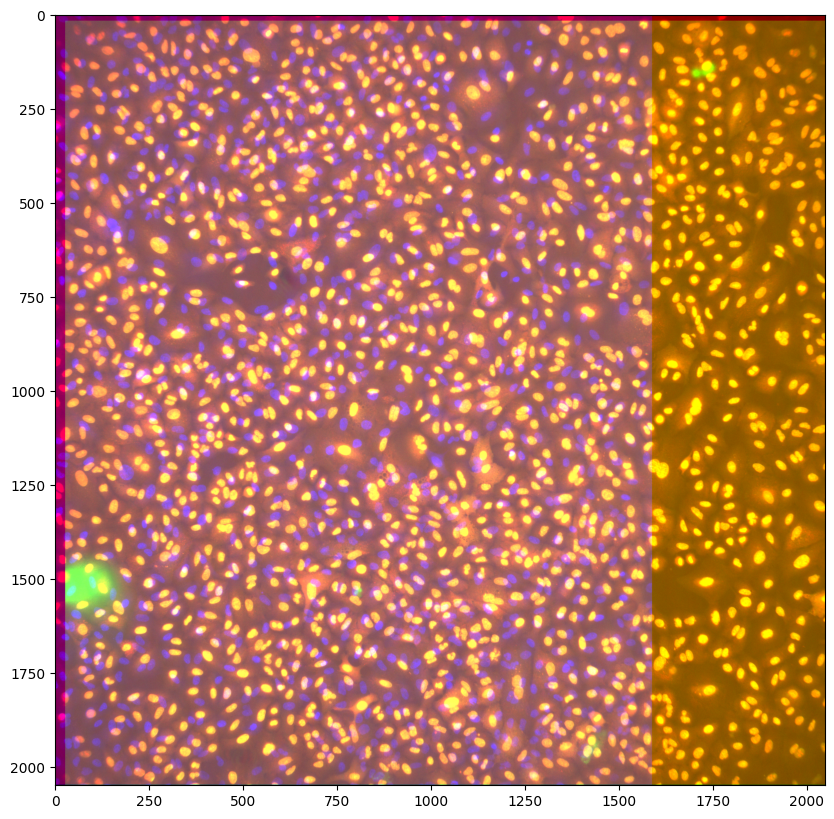

In [9]:
# as visualized below, cycle 9 in this acquisition had an offset from the rest of the acquisitions. 
# this breaks the field of view correspondence assumption for all baseline methods. This emphasizes the improved benefit of our
# method when analyzing ISS data when the data is acquired from different microscopes potentially with a shift across cycles
# For comparison with baselines, we drop this cycle across all methods for a fair comparison

plt.figure(figsize=(10,10))
plt.imshow(np.array([aligned_image[0][-1], aligned_image[7][-1], aligned_image[8][-1]]).transpose(1,2,0)/10000)

In [10]:
# skip cycle 9 (index = 8) as the acquisition breaks field of view correspondance asusmption
barcode_indices = [0,1,2,3,4,5,6,7,9]

## Call Barcodes using BarDensr

In [11]:
# compute_barcodes from bardensr
bardensr_detected_barcodes_matched_to_codebook = bardensr.call_barcodes(image_array, codebook_filename="./datasets/sample_dataset/sgRNA_library.pq", barcode_indices=barcode_indices)

W0000 00:00:1729722159.301307  127048 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-10-23 22:22:50.000954: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20803747840 exceeds 10% of free system memory.
2024-10-23 22:23:11.874320: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20803747840 exceeds 10% of free system memory.


## Call Barcodes using Starfish

In [12]:
# compute barcodes from StarFish
starfish_detected_barcodes = starfish.call_barcodes(image_array, codebook_filename="./datasets/sample_dataset/sgRNA_library.pq", barcode_indices=barcode_indices)

/home/ubuntu/miniconda3/envs/insitro/lib/python3.11/site-packages/starfish/core/imagestack/imagestack.py:413: UserWarning: ImageStack detected as uint16. Converting to float32...
  warnings.warn(f"ImageStack detected as {array.dtype}. Converting to float32...")
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 149.24it/s]


In [77]:
# filter starfish barcodes matched to codebook
starfish_detected_barcodes_matched_to_codebook = starfish_detected_barcodes[starfish_detected_barcodes.target!='nan']

## Load Barcodes called using FCN (proposed method)
Use the `1_sequence_and_assign_barcodes_to_cellpaint_images.ipynb` notebook to generate barcodes using our proposed method

In [100]:
# load barcodes from FCN + coordinate space alignment (our proposed methodology)
barcodes_fcn_mapped_to_library = pd.read_parquet("./outputs/barcodes_fcn_mapped_to_library.pq")
# select barcodes in the given field of view
# use source_x, source_y and source_field_id (as we're doing comparison at the first SBS cycle)
barcodes_fcn_mapped_to_library = barcodes_fcn_mapped_to_library[['source_field_id', 'gene_id', 'source_x', 'source_y']].rename(columns={'source_x': 'x', 'source_y': 'y', 'gene_id': 'target', 'source_field_id': 'field_id'})
barcodes_fcn_all = pd.read_parquet("./outputs/barcodes_fcn_all.pq")
barcodes_fcn_all = barcodes_fcn_all[['source_field_id', 'source_x', 'source_y']].rename(columns={'source_x': 'x', 'source_y': 'y', 'source_field_id': 'field_id'})

# select results corresponding to test field id
fcn_detected_barcodes = barcodes_fcn_all[barcodes_fcn_all.field_id==test_field_id]
fcn_detected_barcodes_matched_to_codebook = barcodes_fcn_mapped_to_library[barcodes_fcn_mapped_to_library.field_id==test_field_id]

In [104]:
# remove detections at the edge of field of view (as those are mapped to adjacent field of views with overlap)
def clean_detections(bc, fov_padding=np.ceil(2048*0.05/2), deduplicate_distance=5):
    bc = bc[(bc.x>fov_padding) & (bc.y>fov_padding) & (bc.x<(2048-fov_padding)) & (bc.y<(2048-fov_padding))]
    bc = utils.deduplicated_barcode_locations(bc, deduplicate_distance)
    return bc

# clean detections matched to codebook
fcn_detected_barcodes_clean = clean_detections(fcn_detected_barcodes_matched_to_codebook)
bardensr_detected_barcodes_clean = clean_detections(bardensr_detected_barcodes_matched_to_codebook)
starfish_detected_barcodes_clean = clean_detections(starfish_detected_barcodes_matched_to_codebook)

# clean all detections (including barcodes not matched to codebook)
fcn_detected_barcodes_clean_all = clean_detections(fcn_detected_barcodes)
starfish_detected_barcodes_clean_all = clean_detections(starfish_detected_barcodes)

In [111]:
# compute nuclei segmentations using CellPose
nuclei_model = models.Cellpose(
    gpu=False,
    model_type="nuclei",
    torch=True,
    net_avg=True,
)

# Cellpose returns masks, flows, styles and diameters, we drop all but masks
nuclei, _, _, _ = nuclei_model.eval(
    [scaling.rescale_intensity(aligned_image[0, 4], min_percentile=1, max_percentile=99, clip=True)],
    channels=[1, 1],
    diameter=None,
    normalize=False,
)

2024-10-23 23:41:15,752 [INFO] >>>> using CPU
2024-10-23 23:41:15,915 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2024-10-23 23:42:00,772 [INFO] estimated cell diameter(s) in 44.86 sec
2024-10-23 23:42:00,773 [INFO] >>> diameter(s) = 
2024-10-23 23:42:00,774 [INFO] [22.79, ]
2024-10-23 23:42:00,775 [INFO] ~~~ FINDING MASKS ~~~
2024-10-23 23:42:57,938 [INFO] >>>> TOTAL TIME 102.02 sec


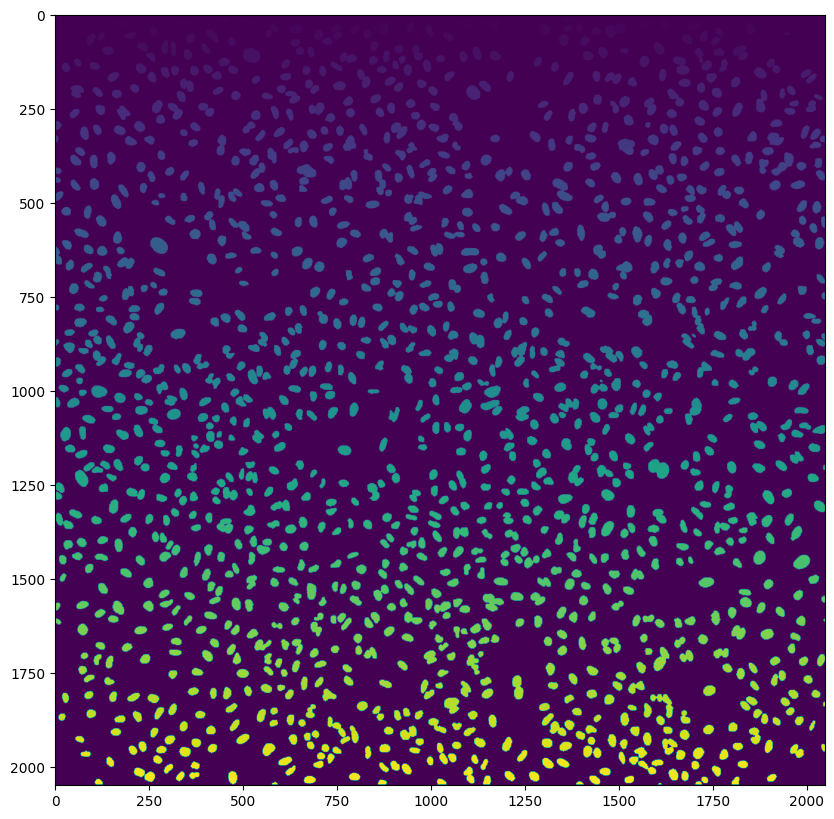

In [115]:
# visualize segmentation mask
plt.figure(figsize=(10,10))
plt.imshow(nuclei[0])

In [129]:
nuclei_mask = nuclei[0]

In [131]:
# compute 2d map of nearest neighboring segmentation label
nearest_neighbor_yx = morphology.distance_transform_edt(
    nuclei_mask == 0, return_distances=False, return_indices=True
)

def assign_label(y, x, nearest_neighbor_yx, nuclei_mask):
    y_, x_ = nearest_neighbor_yx[:, int(y), int(x)]
    return nuclei_mask[y_, x_]

/tmp/ipykernel_127048/1349384612.py:2: DeprecationWarning: Please import `distance_transform_edt` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  nearest_neighbor_yx = morphology.distance_transform_edt(


In [135]:
# assign barcodes to cell labels
fcn_detected_barcodes_clean['cell_label'] = fcn_detected_barcodes_clean.apply(lambda row: assign_label(row.y, row.x, nearest_neighbor_yx=nearest_neighbor_yx, nuclei_mask=nuclei_mask), axis=1)
starfish_detected_barcodes_clean['cell_label'] = starfish_detected_barcodes_clean.apply(lambda row: assign_label(row.y, row.x, nearest_neighbor_yx=nearest_neighbor_yx, nuclei_mask=nuclei_mask), axis=1)
bardensr_detected_barcodes_clean['cell_label'] = bardensr_detected_barcodes_clean.apply(lambda row: assign_label(row.y, row.x, nearest_neighbor_yx=nearest_neighbor_yx, nuclei_mask=nuclei_mask), axis=1)

In [141]:
print("=======================================================================================================")
print("Number of Barcodes (matched to codebook) Detected - True Positives")
print("=======================================================================================================")
print("FCN (proposed) = ", len(fcn_detected_barcodes_clean))
print("Starfish = ", len(starfish_detected_barcodes_clean))
print("BarDensr = ", len(bardensr_detected_barcodes_clean))

print("=======================================================================================================")
print("Total Number of Barcodes (matched to codebook) Detected - True Positives + False Positives")
print("=======================================================================================================")
print("FCN (proposed) = ", len(fcn_detected_barcodes_clean_all))
print("Starfish = ", len(starfish_detected_barcodes_clean_all))
print("BarDensr = Not Computed")

print("=======================================================================================================")
print("Precision")
print("=======================================================================================================")
print("FCN (proposed) = ", len(fcn_detected_barcodes_clean)/len(fcn_detected_barcodes_clean_all))
print("Starfish = ", len(starfish_detected_barcodes_clean)/len(starfish_detected_barcodes_clean_all))
print("BarDensr = Not Computed")

print("=======================================================================================================")
print(f"Cell Recovery Rate (Cells that have a valid codebook matched barcode) - Total Number of Cells = {len(np.unique(nuclei_mask))-1}")
print("=======================================================================================================")
print("FCN (proposed) = ", len(fcn_detected_barcodes_clean.cell_label.unique())/(len(np.unique(nuclei_mask))-1))
print("Starfish = ", len(starfish_detected_barcodes_clean.cell_label.unique())/(len(np.unique(nuclei_mask))-1))
print("BarDensr = ", len(bardensr_detected_barcodes_clean.cell_label.unique())/(len(np.unique(nuclei_mask))-1))
print("=======================================================================================================")


Number of Barcodes (matched to codebook) Detected - True Positives
FCN (proposed) =  3189
Starfish =  2432
BarDensr =  1973
Total Number of Barcodes (matched to codebook) Detected - True Positives + False Positives
FCN (proposed) =  3867
Starfish =  4170
BarDensr = Not Computed
Precision
FCN (proposed) =  0.8246702870442203
Starfish =  0.5832134292565947
BarDensr = Not Computed
Cell Recovery Rate (Cells that have a valid codebook matched barcode) - Total Number of Cells = 1587
FCN (proposed) =  0.7114051669817265
Starfish =  0.626339004410838
BarDensr =  0.5759294265910523


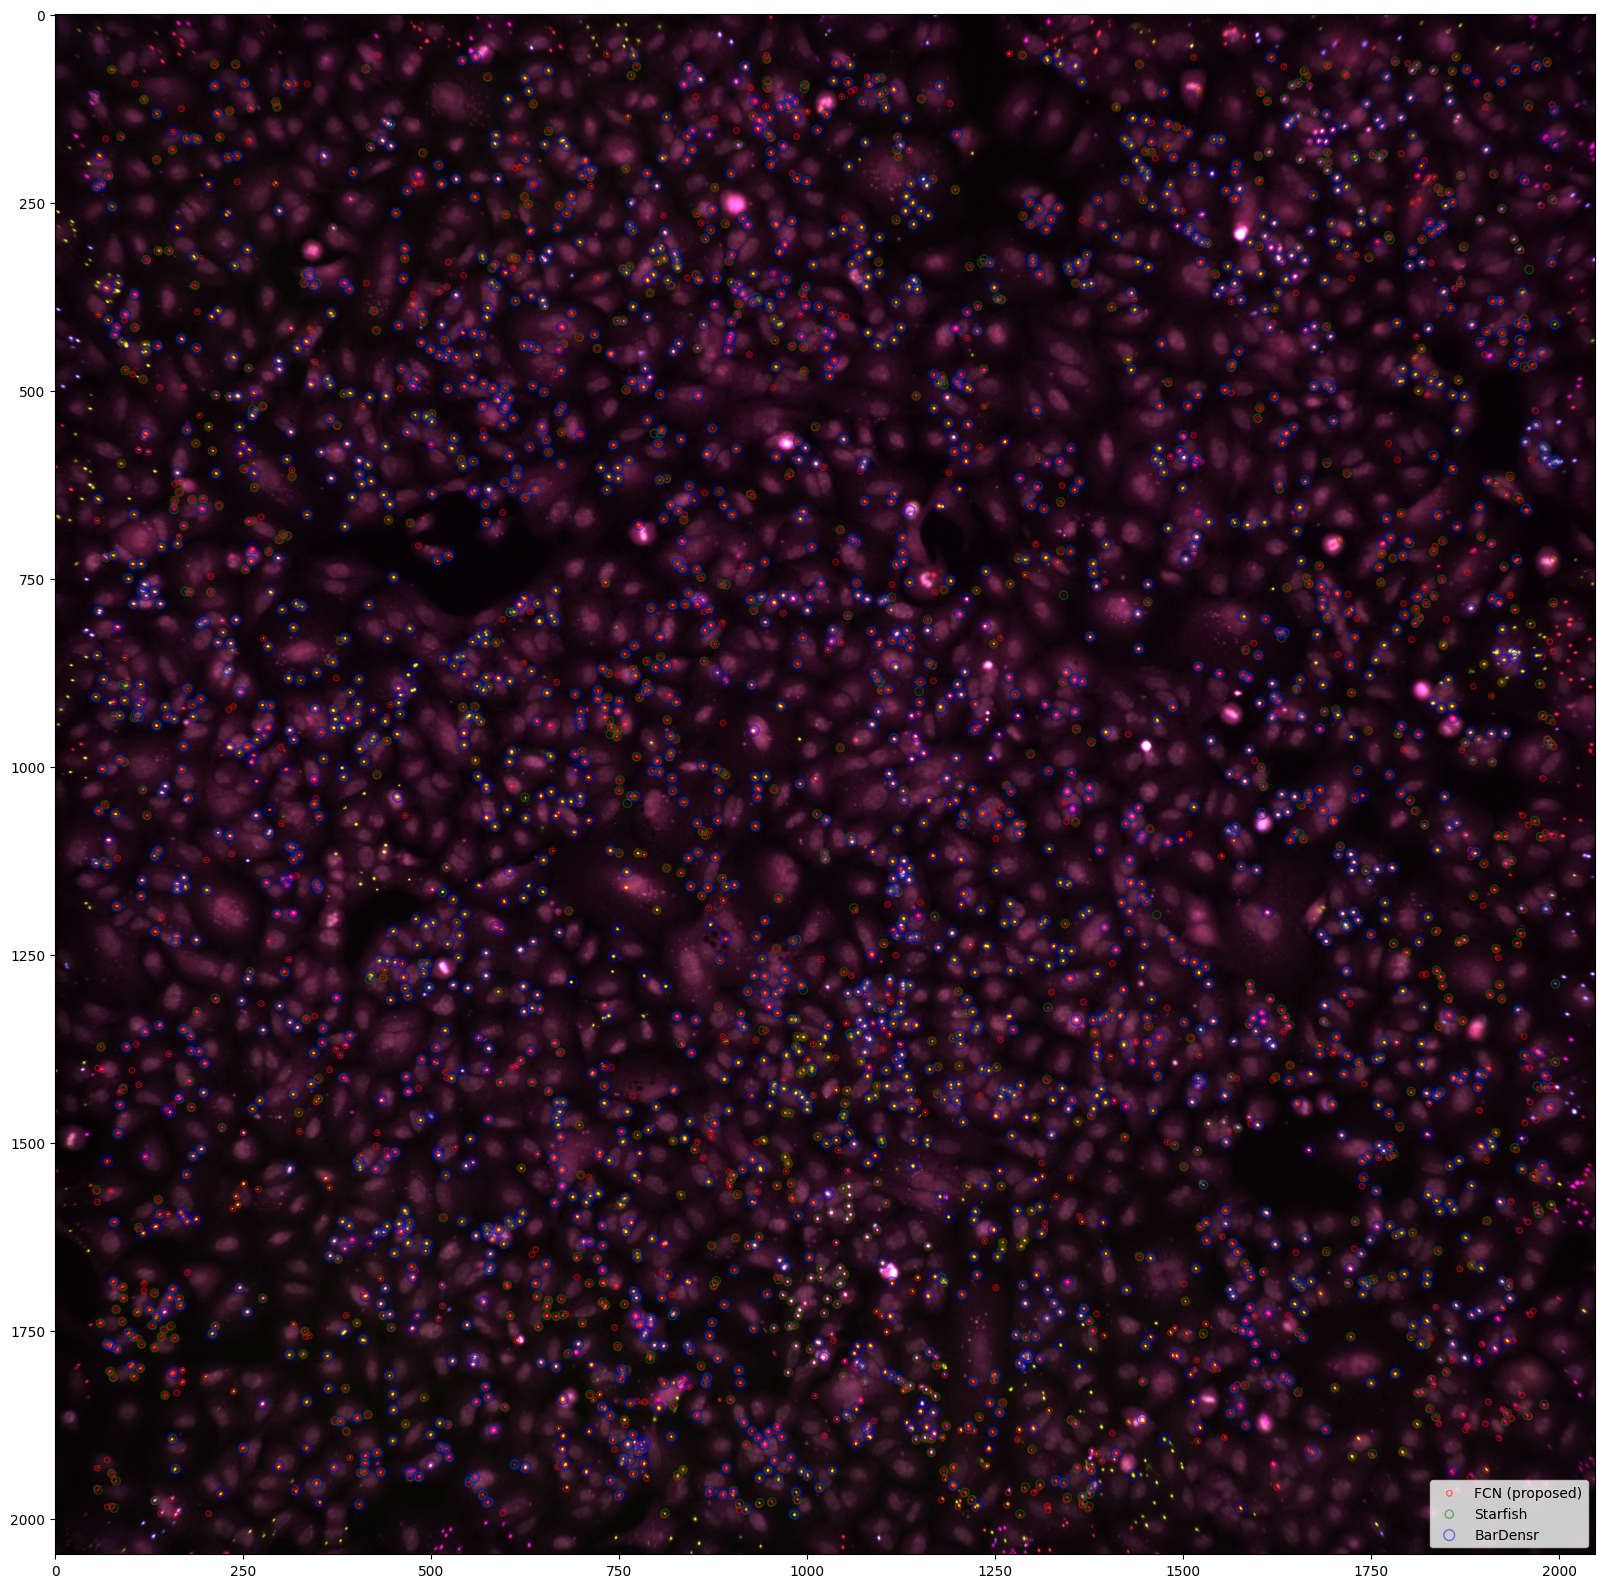

In [80]:
# Visualize barcode detections between FCN (proposed), Starfish and BarDensr methodologies
plt.figure(figsize=(20,20))
plt.imshow(viz.create_composite_image(scaling.rescale_intensity(np.array(aligned_image[0, 0:4])).transpose(1,2,0)))
plt.scatter(fcn_detected_barcodes_clean.x, fcn_detected_barcodes_clean.y, s=16, edgecolors='r', facecolors='none', alpha=0.5, label="FCN (proposed)")
plt.scatter(starfish_detected_barcodes_clean.x, starfish_detected_barcodes_clean.y, s=35, edgecolors='g', facecolors='none', alpha=0.5, label="Starfish")
plt.scatter(bardensr_detected_barcodes_clean.x, bardensr_detected_barcodes_clean.y, s=60, edgecolors='b', facecolors='none', alpha=0.5, label="BarDensr")
plt.legend()

In [ ]:
# consistency of barcode detections (venn diagram of overlap in barcodes)

/home/ubuntu/miniconda3/envs/insitro/lib/python3.11/site-packages/matplotlib_venn/_util.py:62: UserWarning: venn3_unweighted is deprecated. Use venn3 with the appropriate layout_algorithm instead.
  warnings.warn(


Text(0.5, 1.0, 'Consistency of Cells Detected with a Barcode across methods')

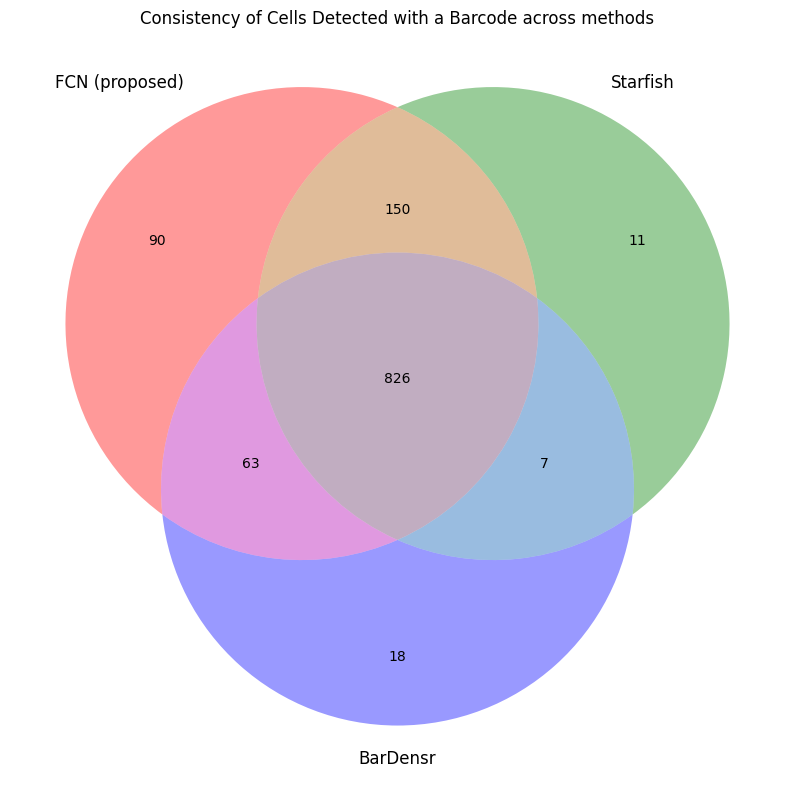

In [153]:
plt.figure(figsize=(10,10))
fcn_set = set(fcn_detected_barcodes_clean.cell_label.unique())
starfish_set = set(starfish_detected_barcodes_clean.cell_label.unique())
bardensr_set = set(bardensr_detected_barcodes_clean.cell_label.unique())
venn = venn3_unweighted([fcn_set, starfish_set, bardensr_set], ('FCN (proposed)', 'Starfish', 'BarDensr'))

plt.title('Consistency of Cells Detected with a Barcode across methods')